# End-to-End Entity Resolution with pyJedAI and Magellan

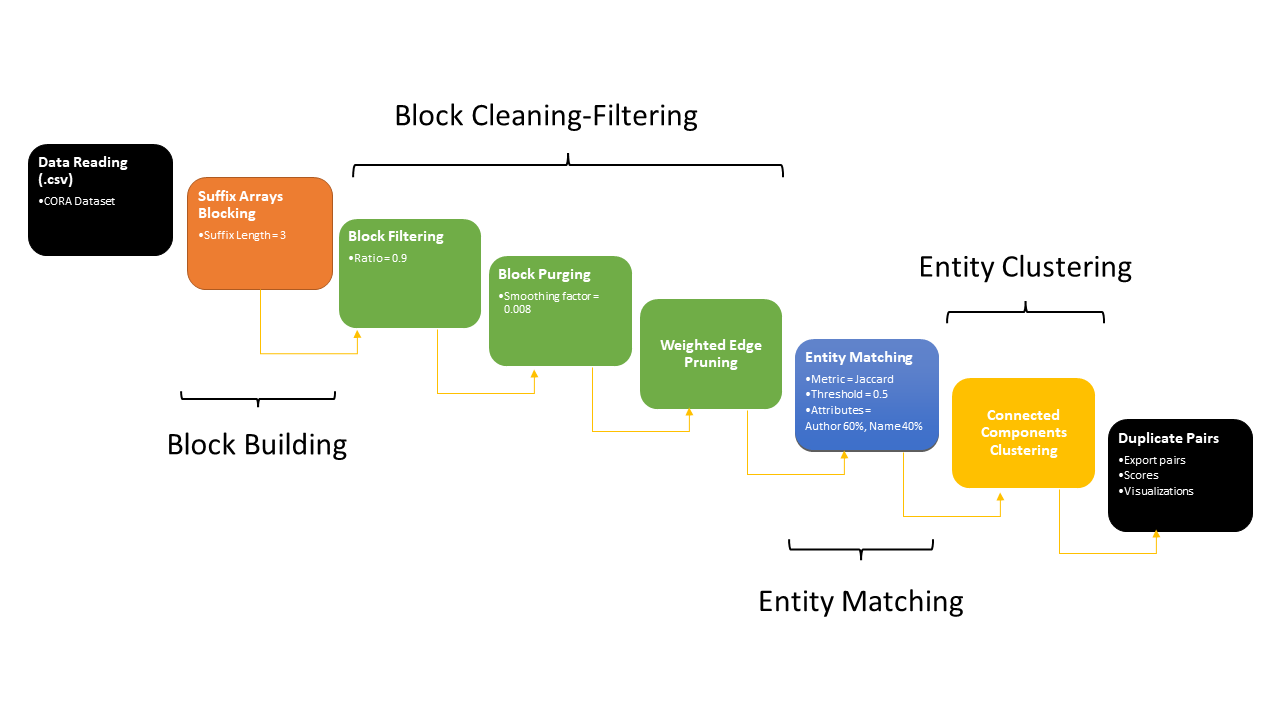

### Load the dataset and the ground truth

In [1]:
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
path_data = "datasets/alaska_cameras_small/"
ds = pd.read_csv(path_data + "dataset.csv")
ds

,_id,description,brand,model,type,mp,price
0,buy.net//4272,nikon coolpix s800c white digital camera (16 m...,nikon,s800c,compact camera,16.0,NaN
1,buy.net//4299,nikon aw1 silver 14.2 megapixel digital camera...,nikon,aw1,NaN,14.2,NaN
2,buy.net//4319,nikon d5300 black slr digital camera kit w/ 18...,nikon,d5300,digital slr camera,24.2,NaN
3,buy.net//4330,sony alpha slta77vm black slr digital camera k...,sony,slta77vm,mirrorless camera,24.3,NaN
4,buy.net//5368,nikon d3300 black slr digital camera kit w/ 18...,nikon,d3300,digital slr camera,24.2,NaN
...,...,...,...,...,...,...,...
5781,www.walmart.com//786,"nikon d3100 14.2mp dslr camera with vr lens, 3...",nikon,d3100,NaN,14.2,NaN
5782,www.walmart.com//787,canon eos 7d 18mp digital slr camera body only...,canon,7d,NaN,18.0,NaN
5783,www.walmart.com//800,sony dsc-w830 b digital camera with 20.1 megap...,sony,dsc-w830,NaN,20.1,NaN
5784,www.walmart.com//808,canon black eos 6d digital slr camera with 20....,canon,6d,NaN,20.2,NaN


In [3]:
gold = pd.read_csv(path_data + "matches.csv")
gold

,l_id,r_id
0,www.ebay.com//46771,www.gosale.com//890
1,www.ebay.com//47592,www.gosale.com//1441
2,www.ebay.com//55710,www.gosale.com//1304
3,www.camerafarm.com.au//793,www.gosale.com//1271
4,www.camerafarm.com.au//730,www.walmart.com//786
...,...,...
11439,www.camerafarm.com.au//807,www.ebay.com//47616
11440,www.ebay.com//44601,www.gosale.com//1404
11441,www.ebay.com//54379,www.gosale.com//804
11442,www.gosale.com//1299,www.gosale.com//735


In [4]:
ds[(ds["_id"] == "www.ebay.com//46771") | (ds["_id"] == "www.gosale.com//890")]

,_id,description,brand,model,type,mp,price
2199,www.ebay.com//46771,nikon d3s 12 1mp digital slr camera body 582 |...,nikon,d3s,digital slr,12.1,NaN
5607,www.gosale.com//890,nikon d3s 12.1mp dslr camera body on sale for ...,nikon,d3s,slr,12.1,4070.97


## Blocking (pyJedAI)

In [5]:
attrs = ["_id", "brand", "model"]

In [6]:
from pyjedai.datamodel import Data

In [7]:
data = Data(
    dataset_1=ds,
    id_column_name_1="_id",
    ground_truth=gold,
    attributes_1=attrs
)

### Block Building

In [8]:
from pyjedai.block_building import (
    StandardBlocking,
    QGramsBlocking,
    ExtendedQGramsBlocking,
    SuffixArraysBlocking,
    ExtendedSuffixArraysBlocking
)

In [9]:
bb = StandardBlocking()
blocks = bb.build_blocks(data)

Standard Blocking:   0%|          | 0/5786 [00:00<?, ?it/s]

In [10]:
_ = bb.evaluate(blocks)

***************************************************************************************************************************
                                         Μethod:  Standard Blocking
***************************************************************************************************************************
Method name: Standard Blocking
Parameters: 
Runtime: 0.1934 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      0.02% 
	Recall:       100.00%
	F1-score:       0.05%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### Block Purging

In [11]:
from pyjedai.block_cleaning import BlockPurging

In [12]:
bp = BlockPurging(smoothing_factor=1.05)
purging_blocks = bp.process(blocks, data, tqdm_disable=False)

Block Purging:   0%|          | 0/1110 [00:00<?, ?it/s]

In [13]:
_ = bp.evaluate(purging_blocks)

***************************************************************************************************************************
                                         Μethod:  Block Purging
***************************************************************************************************************************
Method name: Block Purging
Parameters: 
	Smoothing factor: 1.05
	Max Comparisons per Block: 10878.0
Runtime: 0.0250 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      6.04% 
	Recall:        88.69%
	F1-score:      11.30%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### Block Filtering

In [14]:
from pyjedai.block_cleaning import BlockFiltering

In [15]:
bf = BlockFiltering(ratio=0.95)
filtering_blocks = bf.process(purging_blocks, data)

Block Filtering:   0%|          | 0/3 [00:00<?, ?it/s]

In [16]:
_ = bf.evaluate(filtering_blocks)

***************************************************************************************************************************
                                         Μethod:  Block Filtering
***************************************************************************************************************************
Method name: Block Filtering
Parameters: 
	Ratio: 0.95
Runtime: 0.4017 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      6.04% 
	Recall:        88.69%
	F1-score:      11.30%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### Comparison Cleaning

In [17]:
from pyjedai.comparison_cleaning import (
    ComparisonPropagation,
    CardinalityEdgePruning,
    CardinalityNodePruning,
    WeightedEdgePruning,
    WeightedNodePruning,
    ReciprocalCardinalityNodePruning,
    ReciprocalWeightedNodePruning,
    BLAST
)

In [18]:
mb = WeightedNodePruning()
comparisons = mb.process(filtering_blocks, data)

Weighted Node Pruning:   0%|          | 0/5786 [00:00<?, ?it/s]

In [19]:
_ = mb.evaluate(comparisons)

***************************************************************************************************************************
                                         Μethod:  Weighted Node Pruning
***************************************************************************************************************************
Method name: Weighted Node Pruning
Parameters: 
	Node centric: True
	Weighting scheme: CBS
Runtime: 2.1068 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      9.12% 
	Recall:        87.69%
	F1-score:      16.53%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### Generate the candidate set

In [20]:
id_mapping = {d[1]: d[0] for d in data._ids_mapping_1.items()}
id_mapping[0]

'buy.net//4272'

In [21]:
import random

In [22]:
candidates = {(id_mapping[cand[0]], id_mapping[cand[1]]) if id_mapping[cand[0]] < id_mapping[cand[1]]
              else (id_mapping[cand[1]], id_mapping[cand[0]]) for cand in [(l_id, r_id) for r_id in comparisons.keys() for l_id in comparisons[r_id]]}
print(random.choice(list(candidates)))
len(candidates)

('buy.net//6670', 'www.gosale.com//1377')


110008

In [23]:
candidates = pd.DataFrame(candidates, columns=["l_id", "r_id"])
candidates

,l_id,r_id
0,cammarkt.com//385,www.ebay.com//43663
1,www.ebay.com//48230,www.ebay.com//52860
2,buy.net//6716,www.gosale.com//1213
3,www.ebay.com//47640,www.ebay.com//53030
4,www.ebay.com//47437,www.ebay.com//53930
...,...,...
110003,www.ebay.com//42607,www.ebay.com//52959
110004,www.ebay.com//47854,www.ebay.com//60231
110005,www.ebay.com//47843,www.ebay.com//59659
110006,www.ebay.com//45064,www.ebay.com//53447


In [24]:
candidates.to_csv("candidates.csv", index=False)

## Entity Matching (Magellan)

In [25]:
import py_entitymatching as em

### Prepare the input dataset

Specify numeric columns and cast any other value to string.

In [26]:
num_cols = ["mp", "price"]
for col in num_cols:
    ds[col] = pd.to_numeric(ds[col])
for col in ds.columns:
    if ds[col].dtype == "object":
        ds[col] = ds[col].str.lower()
ds.dtypes

_id             object
description     object
brand           object
model           object
type            object
mp             float64
price          float64
dtype: object

Set the key and collect useful attributes (excluding the ID).

In [27]:
em.set_key(ds, "_id")
attrs = [attr for attr in ds.columns if attr != "_id"]
attrs

['description', 'brand', 'model', 'type', 'mp', 'price']

### Load and prepare the labeled dataset

In [28]:
labels = pd.read_csv(path_data + "labels.csv")
labels = labels.reset_index()
labels = labels.rename(columns={"index": "_id", "l_id": "ltable_id", "r_id": "rtable_id"})
labels

,_id,ltable_id,rtable_id,label
0,0,www.ebay.com//48590,www.gosale.com//985,1
1,1,www.ebay.com//46753,www.gosale.com//1123,1
2,2,www.ebay.com//60463,www.gosale.com//919,1
3,3,www.ebay.com//43204,www.gosale.com//1318,1
4,4,www.camerafarm.com.au//788,www.ebay.com//48291,1
...,...,...,...,...
15995,15995,www.ebay.com//58508,www.ebay.com//59301,0
15996,15996,www.buzzillions.com//2324,www.gosale.com//917,0
15997,15997,www.ebay.com//47008,www.ebay.com//58087,0
15998,15998,www.ebay.com//57169,www.pcconnection.com//12386,0


In [29]:
labels = labels.join(ds.set_index("_id"), on="ltable_id")
labels = labels.rename(columns={attr: "ltable_" + attr for attr in attrs})
labels = labels.join(ds.set_index("_id"), on="rtable_id")
labels = labels.rename(columns={attr: "rtable_" + attr for attr in attrs})
em.set_key(labels, "_id")
labels

,_id,ltable_id,rtable_id,label,ltable_description,ltable_brand,ltable_model,ltable_type,ltable_mp,ltable_price,rtable_description,rtable_brand,rtable_model,rtable_type,rtable_mp,rtable_price
0,0,www.ebay.com//48590,www.gosale.com//985,1,nikon d3100 14 2 mp digital slr camera with 18 55mm zoom lens | ebay,nikon,d3100,digital slr,14.2,NaN,nikon d3100 14.2mp digital slr camera on sale for $461.20,nikon,d3100,slr,14.2,654.81
1,1,www.ebay.com//46753,www.gosale.com//1123,1,canon eos rebel t5i 700d 18 0 mp digital slr camera plus more 013803222425 | ebay,canon,t5i,digital slr,18.0,NaN,canon eos rebel t5i 18.0 mp cmos digital on sale for $589.99,canon,t5i,slr,18.0,620.31
2,2,www.ebay.com//60463,www.gosale.com//919,1,canon 12 2mp eos rebel t3 ds126291 dslr camera w 18 55 ef s lens 013803136340 | ebay,canon,t3,digital slr,12.2,NaN,canon eos rebel t3 12.2mp digital slr on sale for $575.99,canon,t3,slr,12.2,516.81
3,3,www.ebay.com//43204,www.gosale.com//1318,1,canon eos rebel xt 350d 8 0 mp digital slr camera 18 55mm lens 013803049626 | ebay,canon,xt,digital slr,8.0,NaN,canon eos digital rebel xt 8mp digital on sale for $705.49,canon,xt,slr,8.0,1034.99
4,4,www.camerafarm.com.au//788,www.ebay.com//48291,1,canon eos 1100d digital slr camera - 12.2mp black (1100dkb) | camerafarm australia,canon,1100d,,12.2,481.9,canon eos rebel t3 eos 1100d 12 2 mp digital slr camera kit 091037258342 | ebay,canon,t3,digital slr,12.2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,15995,www.ebay.com//58508,www.ebay.com//59301,0,canon eos rebel t3 1100d 12 2 mp digital slr camera black body only | ebay,canon,t3,digital slr,12.2,NaN,nikon d80 10 2 mp digital slr camera black body only 018208254125 | ebay,nikon,d80,digital slr,10.2,NaN
15996,15996,www.buzzillions.com//2324,www.gosale.com//917,0,nikon coolpix s3000 12.0 megapixel 4x vr (vibration-reduction) optical zoom reviews | buzzillion...,nikon,s3000,,12.0,NaN,nikon coolpix p600 16.1mp wi-fi digital on sale for $353.13,nikon,p600,point-and-shoot,16.1,344.97
15997,15997,www.ebay.com//47008,www.ebay.com//58087,0,canon powershot sx50 hs 12 1 mp digital camera black new in unopen retail box | ebay,canon,sx50,bridge camera,12.1,NaN,canon powershot sx50 hs 12 1 mp digital camera black | ebay,canon,sx50,bridge camera,12.1,NaN
15998,15998,www.ebay.com//57169,www.pcconnection.com//12386,0,nikon d200 10 2 mp digital slr camera body and everything shown 018208252350 | ebay,nikon,d200,digital slr,10.2,NaN,"buy canon eos 60d digital slr, 18mp - body only cameras - digital - slr 4460b003 today at pc con...",canon,60d,slr camera,18.0,NaN


In [30]:
labels.to_csv("labels_expanded.csv", index=False)

### Split the labeled data into train and test sets

In [31]:
labels = em.read_csv_metadata(
    "labels_expanded.csv",
    key="_id",
    ltable=ds, rtable=ds,
    fk_ltable="ltable_id", fk_rtable="rtable_id"
)

Metadata file is not present in the given path; proceeding to read the csv file.


In [32]:
train_test = em.split_train_test(labels, train_proportion=0.7, random_state=0)
train = train_test["train"]
test = train_test["test"]

### Train the model

ML models supported by Magellan:

- Decision Tree: em.DTMatcher(name='DecisionTree', random_state=0)
- SVM: em.SVMMatcher(name='SVM', random_state=0)
- Random Forest: em.RFMatcher(name='RF', random_state=0)
- Logistic Regression: em.LogRegMatcher(name='LogReg', random_state=0)
- Linear Regression: em.LinRegMatcher(name='LinReg')
- Naive Bayes: em.NBMatcher(name='NaiveBayes')

In [33]:
model = em.DTMatcher()

Define the features.

In [34]:
feature_attrs = ["brand", "model", "type", "mp"]
feature_table = em.get_features_for_matching(ds[feature_attrs], ds[feature_attrs], validate_inferred_attr_types=False)
list(feature_table["feature_name"])

['brand_brand_lev_dist',
 'brand_brand_lev_sim',
 'brand_brand_jar',
 'brand_brand_jwn',
 'brand_brand_exm',
 'brand_brand_jac_qgm_3_qgm_3',
 'model_model_jac_qgm_3_qgm_3',
 'model_model_cos_dlm_dc0_dlm_dc0',
 'model_model_jac_dlm_dc0_dlm_dc0',
 'model_model_mel',
 'model_model_lev_dist',
 'model_model_lev_sim',
 'model_model_nmw',
 'model_model_sw',
 'type_type_jac_qgm_3_qgm_3',
 'type_type_cos_dlm_dc0_dlm_dc0',
 'type_type_jac_dlm_dc0_dlm_dc0',
 'type_type_mel',
 'type_type_lev_dist',
 'type_type_lev_sim',
 'type_type_nmw',
 'type_type_sw',
 'mp_mp_exm',
 'mp_mp_anm',
 'mp_mp_lev_dist',
 'mp_mp_lev_sim']

Generate the feature vectors.

In [35]:
attrs_from_table = [attr for attr in labels.columns if attr not in ["_id", "ltable_id", "rtable_id", "label"]]
attrs_from_table

['ltable_description',
 'ltable_brand',
 'ltable_model',
 'ltable_type',
 'ltable_mp',
 'ltable_price',
 'rtable_description',
 'rtable_brand',
 'rtable_model',
 'rtable_type',
 'rtable_mp',
 'rtable_price']

In [36]:
train_feature_vecs = em.extract_feature_vecs(
    train,
    feature_table=feature_table,
    attrs_before=attrs_from_table,
    attrs_after="label",
    show_progress=True
)

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


Train the model.

In [37]:
attrs_to_be_excluded = []
attrs_to_be_excluded.extend(["_id", "ltable_id", "rtable_id", "label"])
attrs_to_be_excluded.extend(attrs_from_table)

In [38]:
model.fit(
    table=train_feature_vecs,
    exclude_attrs=attrs_to_be_excluded,
    target_attr="label"
)

### Evaluate the model on the test set

Generate the feature vectors.

In [39]:
test_feature_vecs = em.extract_feature_vecs(
    test,
    feature_table=feature_table,
    attrs_before=attrs_from_table,
    attrs_after="label",
    show_progress=True
)

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04


Predict the label for the pairs in the test set.

In [40]:
test_predictions = model.predict(
    table=test_feature_vecs,
    exclude_attrs=attrs_to_be_excluded,
    target_attr="predicted",
    return_probs=True,
    probs_attr="weight",
    append=True,
    inplace=False
)
test_predictions[["ltable_id", "rtable_id", "predicted", "weight"]]

,ltable_id,rtable_id,predicted,weight
841,www.ebay.com//42844,www.gosale.com//882,1,1.0
8650,www.ebay.com//25035,www.ebay.com//54402,0,0.0
3701,www.ebay.com//44805,www.gosale.com//563,1,1.0
13270,www.ebay.com//53260,www.ebay.com//59543,0,0.0
12349,www.ebay.com//42498,www.gosale.com//930,0,0.0
...,...,...,...,...
4657,www.ebay.com//53670,www.ebay.com//59953,0,0.0
2594,www.ebay.com//52821,www.gosale.com//1404,1,1.0
850,www.camerafarm.com.au//754,www.ebay.com//60532,1,1.0
4016,www.ebay.com//48445,www.ebay.com//60673,0,0.0


Compute precision, recall, and F-score.

In [41]:
test_pairs = {(pair[0], pair[1]) if pair[0] <= pair[1] else (pair[1], pair[0])
              for pair in list(test_predictions[["ltable_id", "rtable_id"]].itertuples(index=False, name=None))}
predicted_matches = {(pair[0], pair[1]) if pair[0] <= pair[1] else (pair[1], pair[0])
                     for pair in list(test_predictions[test_predictions["predicted"] == 1][["ltable_id", "rtable_id"]].itertuples(index=False, name=None))}
matches = {(pair[0], pair[1]) if pair[0] <= pair[1] else (pair[1], pair[0])
           for pair in list(gold[["l_id", "r_id"]].itertuples(index=False, name=None))}.intersection(test_pairs)
tp = len(predicted_matches.intersection(matches))
fp = len(predicted_matches.difference(matches))
fn = len(matches.difference(predicted_matches))
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f_score = (2 * precision * recall) / (precision + recall)
"Precision: " + str(round(precision * 100, 3)) + "% | Recall: " + str(round(recall * 100, 3)) + "% | F-score: " + str(round(f_score * 100, 3)) + "%"

'Precision: 98.705% | Recall: 98.619% | F-score: 98.662%'

### Load and prepare the candidate set

In [42]:
candidates = pd.read_csv("candidates.csv")
candidates = candidates.reset_index()
candidates = candidates.rename(columns={"index": "_id", "l_id": "ltable_id", "r_id": "rtable_id"})
candidates

,_id,ltable_id,rtable_id
0,0,cammarkt.com//385,www.ebay.com//43663
1,1,www.ebay.com//48230,www.ebay.com//52860
2,2,buy.net//6716,www.gosale.com//1213
3,3,www.ebay.com//47640,www.ebay.com//53030
4,4,www.ebay.com//47437,www.ebay.com//53930
...,...,...,...
110003,110003,www.ebay.com//42607,www.ebay.com//52959
110004,110004,www.ebay.com//47854,www.ebay.com//60231
110005,110005,www.ebay.com//47843,www.ebay.com//59659
110006,110006,www.ebay.com//45064,www.ebay.com//53447


In [43]:
candidates = candidates.join(ds.set_index("_id"), on="ltable_id")
candidates = candidates.rename(columns={attr: "ltable_" + attr for attr in attrs})
candidates = candidates.join(ds.set_index("_id"), on="rtable_id")
candidates = candidates.rename(columns={attr: "rtable_" + attr for attr in attrs})
em.set_key(candidates, "_id")
candidates

,_id,ltable_id,rtable_id,ltable_description,ltable_brand,ltable_model,ltable_type,ltable_mp,ltable_price,rtable_description,rtable_brand,rtable_model,rtable_type,rtable_mp,rtable_price
0,0,cammarkt.com//385,www.ebay.com//43663,cammarkt | canon eos rebel t5i 18.0 mp cmos digital slr with 18-55mm ef-s i,canon,t5i,,18.0,NaN,canon eos rebel t5i 700d 18 0 mp digital slr camera black kit w is stm 013803222449 | ebay,canon,t5i,digital slr,18.0,NaN
1,1,www.ebay.com//48230,www.ebay.com//52860,nikon d5100 16 2 mp digital slr camera body great camera 23559 | ebay,nikon,d5100,digital slr,16.2,NaN,mint nikon d5100 16 2 mp digital slr camera black kit w 18 55 mm vr lens 018208254781 | ebay,nikon,d5100,digital slr,16.2,NaN
2,2,buy.net//6716,www.gosale.com//1213,"panasonic lumix dmc-gh4 black digital camera (16.05 mp, sd/sdhc/sdxc card slot) price comparison...",panasonic,dmc-gh4,mirrorless interchangeable lens camera,16.1,NaN,panasonic lumix dmc-lx7w 10.1mp digital on sale for $322.22,panasonic,dmc-lx7w,point-and-shoot,10.1,344.99
3,3,www.ebay.com//47640,www.ebay.com//53030,canon eos rebel t3i 600d 18 0 mp digital slr camera black kit w ef s is | ebay,canon,t3i,digital slr,18.0,NaN,canon eos rebel t3i 600d digital slr camera 18 0mp black body only 013803134230 | ebay,canon,t3i,digital slr,18.0,NaN
4,4,www.ebay.com//47437,www.ebay.com//53930,nikon d800 36 3 mp cmos fx format digital slr camera great camera 23393 018208254804 | ebay,nikon,d800,digital slr,36.3,NaN,nikon d800 digital slr camera body only 36 3 megapixel full 1080p hd video 018208254804 | ebay,nikon,d800,,36.3,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110003,110003,www.ebay.com//42607,www.ebay.com//52959,nikon d3200 24 2mp digital slr camera body | ebay,nikon,d3200,digital slr,24.2,NaN,nikon d3200 dslr camera 24 2 mp bundle 18 55mm new 55 200 lens kit 1080 vid | ebay,nikon,d3200,single-lens reflex digital camera,24.2,NaN
110004,110004,www.ebay.com//47854,www.ebay.com//60231,nikon d90 12 3mp digital slr camera w 18 105mm f 3 5 5 6 g af s vr lens 240936 | ebay,nikon,d90,digital slr,12.3,NaN,nikon d90 12 3 mp dslr in great condition black w vr 18 200mm lens | ebay,nikon,d90,digital slr,12.3,NaN
110005,110005,www.ebay.com//47843,www.ebay.com//59659,canon eos 5d mark ii 21 1 mp digital slr camera kit w ef 24 70mm l usm lens 5055147552252 | ebay,canon,5d mark ii,digital slr,21.1,NaN,canon eos 5d mark ii 21 1 mega pixel digital slr camera black body only 013803105384 | ebay,canon,5d mark ii,digital slr,21.1,NaN
110006,110006,www.ebay.com//45064,www.ebay.com//53447,nikon d3100 14 2 mp digital slr camera black kit w bundle 3 1588 | ebay,nikon,d3100,digital slr,14.2,NaN,nikon d3100 14 2 mp dslr kit w af s dx vr 18 55mm lens 018208254866 | ebay,nikon,d3100,digital slr,14.2,NaN


In [44]:
candidates.to_csv("candidates_expanded.csv", index=False)

### Predict the labels for the candidates

In [45]:
candidates = em.read_csv_metadata(
    "candidates_expanded.csv",
    key="_id",
    ltable=ds, rtable=ds,
    fk_ltable="ltable_id", fk_rtable="rtable_id"
)

Metadata file is not present in the given path; proceeding to read the csv file.


Generate the feature vectors.

In [46]:
pred_feature_vecs = em.extract_feature_vecs(
    candidates,
    feature_table=feature_table,
    attrs_before=attrs_from_table,
    show_progress=True
)

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:01:15


Predict the labels for the candidates.

In [47]:
attrs_to_be_excluded = []
attrs_to_be_excluded.extend(["_id", "ltable_id", "rtable_id"])
attrs_to_be_excluded.extend(attrs_from_table)

In [48]:
predictions = model.predict(
    table=pred_feature_vecs,
    exclude_attrs=attrs_to_be_excluded,
    target_attr="predicted",
    return_probs=True,
    probs_attr="weight",
    append=True,
    inplace=False
)
predictions[["ltable_id", "rtable_id", "predicted", "weight"]]

,ltable_id,rtable_id,predicted,weight
0,cammarkt.com//385,www.ebay.com//43663,1,0.993865
1,www.ebay.com//48230,www.ebay.com//52860,0,0.000000
2,buy.net//6716,www.gosale.com//1213,0,0.000000
3,www.ebay.com//47640,www.ebay.com//53030,0,0.000000
4,www.ebay.com//47437,www.ebay.com//53930,1,1.000000
...,...,...,...,...
110003,www.ebay.com//42607,www.ebay.com//52959,1,1.000000
110004,www.ebay.com//47854,www.ebay.com//60231,0,0.000000
110005,www.ebay.com//47843,www.ebay.com//59659,0,0.000000
110006,www.ebay.com//45064,www.ebay.com//53447,0,0.000000


In [49]:
predicted_matches = {(pair[0], pair[1]) if pair[0] <= pair[1] else (pair[1], pair[0])
                     for pair in list(predictions[predictions["predicted"] == 1][["ltable_id", "rtable_id"]].itertuples(index=False, name=None))}
matches = {(pair[0], pair[1]) if pair[0] <= pair[1] else (pair[1], pair[0])
           for pair in list(gold[["l_id", "r_id"]].itertuples(index=False, name=None))}
tp = len(predicted_matches.intersection(matches))
fp = len(predicted_matches.difference(matches))
fn = len(matches.difference(predicted_matches))
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f_score = (2 * precision * recall) / (precision + recall)
"Precision: " + str(round(precision * 100, 3)) + "% | Recall: " + str(round(recall * 100, 3)) + "% | F-score: " + str(round(f_score * 100, 3)) + "%"

'Precision: 42.078% | Recall: 87.321% | F-score: 56.79%'

In [50]:
predictions[["ltable_id", "rtable_id", "weight"]].to_csv("predictions.csv", index=False)